## Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Scientists and Futurists

### Notebook 2 of 3: Modeling

#### Libary imports

In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

import warnings; warnings.simplefilter('ignore')
##this will hide deprecation/future warnings

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

In [530]:
# Read in the cleaned data
subred = pd.read_csv('../data/cleaned_data/cleaned_df.csv')

# Check its shape
display(subred.shape)

# Preview
subred.head()

(3137, 2)

,subreddit,title
0,futurology,robot encroach on up to million job around the world
1,futurology,measur in ai polici opportun and challeng
2,futurology,how egypt is grow forest in middl of the desert
3,futurology,energi scaveng nanogener find power all around us
4,futurology,there are polit and cultur problem that occur with social chang in a societi with high andor rise life expect


#### Set the features

In [531]:
# Set feature matrix and target variable
X = subred['title']
y = subred['subreddit']

### Identify an optimal model with a pipeline and GridSearch

### Train-test split

In [532]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,             # equal balance of yes and no in train and test
                                                    random_state = 42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2101,)
y_train shape: (2101,) 

X_test shape: (1036,)
y_test shape: (1036,)


### Baseline accuracy

**50.1% is the baseline accuracy percentage we compare with the model's accuracy.**

**If the model does better than the baseline, then it is better than null model (predicting the majority class).**

In [533]:
printmd('**Balance of classes in `y`**')
display(y.value_counts(normalize=True))

printmd('**Balance of classes in `y_train`**')
display(y_train.value_counts(normalize=True))

printmd('**Balance of classes in `y_test`**')
y_test.value_counts(normalize=True)

**Balance of classes in `y`**

futurology    0.501753
science       0.498247
Name: subreddit, dtype: float64

**Balance of classes in `y_train`**

futurology    0.501666
science       0.498334
Name: subreddit, dtype: float64

**Balance of classes in `y_test`**

futurology    0.501931
science       0.498069
Name: subreddit, dtype: float64

## Cutoff point 

### Pipeline 1



**CountVectorizer (transformer)**



**Random Forest (estimator)**

In [496]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Random Forest (estimator)

pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier()) 
])


# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_rf_params = {
    'cvec__max_features': [5_000],
    'cvec__min_df': [1],
    'cvec__max_df': [.75],
    'cvec__ngram_range': [(1,1)],
    'rf__n_estimators': [100, 200], 
    'rf__max_depth': [None, .25],
    'rf__max_features': ['auto', 2_000]
}

# Instantiate GridSearchCV.

gs_cvec_rf = GridSearchCV(pipe_cvec_rf,             # the object we are optimizing
                  param_grid = pipe_cvec_rf_params, # the parameters values we are searching
                  cv = 5)                           # Number of folds in cross-validation

In [497]:
# Fit GridSearch to data.
gs_cvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.75], 'cvec__max_features': [5000],
                         'cvec__min_df': [1], 'cvec__ngram_range': [(1, 1)],
                         'rf__max_depth': [None, 0.25],
                         'rf__max_features': ['auto', 2000],
                         'rf__n_estimators': [100, 200]})

#### Evaluate the model

In [498]:
printmd('**Grid searched:**')
display(gs_cvec_rf.param_grid)
printmd(f'**Best accuracy score**: {round(gs_cvec_rf.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_cvec_rf.best_estimator_)
display(gs_cvec_rf.best_params_)
printmd('**Accuracy score on train set:**')
display(gs_cvec_rf.score(X_train, y_train))
printmd('**Accuracy score on test set:**')
display(gs_cvec_rf.score(X_test, y_test))



**Grid searched:**

{'cvec__max_features': [5000],
 'cvec__min_df': [1],
 'cvec__max_df': [0.75],
 'cvec__ngram_range': [(1, 1)],
 'rf__n_estimators': [100, 200],
 'rf__max_depth': [None, 0.25],
 'rf__max_features': ['auto', 2000]}

**Best accuracy score**: 0.832

**Best estimator / parameters:**

Pipeline(steps=[('cvec', CountVectorizer(max_df=0.75, max_features=5000)),
                ('rf', RandomForestClassifier(n_estimators=200))])

{'cvec__max_df': 0.75,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__n_estimators': 200}

**Accuracy score on train set:**

1.0

**Accuracy score on test set:**

0.833976833976834

In [481]:
# Instantiate CountVectorizer
cvec = CountVectorizer(max_df = 0.75, max_features = 5_000, min_df = 1, ngram_range = (1, 1), stop_words = 'english')

# Fit the features training data so the model learns the vocabulary; transform to create vectors from the vocabulary
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                           columns = cvec.get_feature_names())

# Fit the features test data so the model learns the vocabulary; 
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(),
                           columns = cvec.get_feature_names())

# Check the shapes 

display(X_train_cvec.shape)
display(y_train.shape)
display(X_test_cvec.shape)
display(y_test.shape)

rf_ex_pipe = RandomForestClassifier(n_estimators = 200)

rf_ex_pipe.fit(X_train_cvec, y_train)

printmd('**Accuracy score on train set:**')
display(rf_ex_pipe.score(X_train_cvec, y_train))
printmd('**Accuracy score on test set:**')
display(rf_ex_pipe.score(X_test_cvec, y_test))


(2101, 5000)

(2101,)

(1036, 5000)

(1036,)

**Accuracy score on train set:**

1.0

**Accuracy score on test set:**

0.8272200772200772

credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_

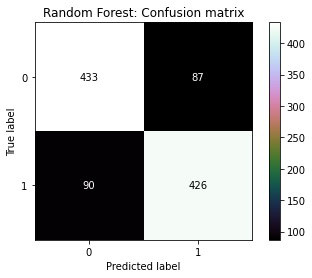

In [484]:
# Get predictions
preds = gs_cvec_rf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(gs_cvec_rf, X_test, y_test, cmap='cubehelix', values_format='d');
plt.title('Random Forest: Confusion matrix')
plt.savefig('../images/confusion_matrix_randomforest.png');

printmd('credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_')

In [482]:
# Calculate the accuracy

acc = (tp + tn) / (tp + fp + tn + fn)
print('Accuracy:', acc)

# Calculate the misclassification rate

misclass = (fp + fn) / (tp + fp + tn + fn)
print('Misclassification:', misclass)

# Calculate the sensitivity

sens = tp / (tp + fn)
print('Sensitivity:', sens)

# Calculate the precision

prec = tp / (tp + fp)
print('Precision:', prec)

# Calculate the specificity

spec = tn / (tn + fp)
print('Specificity:', spec)

# credit: Heather Robinson :-)

Accuracy: 0.8291505791505791
Misclassification: 0.17084942084942084
Sensitivity: 0.8255813953488372
Precision: 0.8304093567251462
Specificity: 0.8326923076923077


| Model # | Accuracy (test) | Accuracy on train data | Specificity (test) |      Estimator      |  Estimator hyperparameters |   Transformer   | Transformer hyperparameters (best) |
|:-------:|:---------------:|:----------------------:|:------------------:|:-------------------:|:--------------------------:|:---------------:|:----------------------------------:|
|    1    |      83.5%      |          99.6%         |        82.7%       | Logistic Regression |           Default          | CountVectorizer |            max_df = 0.4            |
|    1    |                 |                        |                    |                     |                            |                 |        max_features = 6_000        |
|    1    |                 |                        |                    |                     |                            |                 |             min_df = 1             |
|    1    |                 |                        |                    |                     |                            |                 |        ngram_range = (1, 2)        |
|    1    |                 |                        |                    |                     |                            |                 |       stop_words = 'english'       |
|    2    |      83.5%      |          99.6%         |        82.7%       | Logistic Regression |       penalty = 'l2'       | CountVectorizer |           Same as model 1          |
|    2    |                 |                        |                    |                     |            C = 1           |                 |                                    |
|    3    |      83.7%      |          99.6%         |        83.1%       | Logistic Regression |       penalty = 'l2'       | CountVectorizer |           Same as model 1          |
|    3    |                 |                        |                    |                     |            C = 1           |                 |                                    |
|    3    |                 |                        |                    |                     |    'solver': 'liblinear'   |                 |                                    |
|    4    |      84.2%      |           1.0          |                    |    Random Forest    |    'rf__max_depth': None   | CountVectorizer |             max_df=0.75            |
|    4    |                 |                        |                    |                     | 'rf__max_features': 'auto' |                 |          max_features=5000         |
|    4    |                 |                        |                    |                     |   'rf__n_estimators': 100  |                 |          'cvec__min_df': 1         |

#### Let's look into the most important features and set up for feature selection

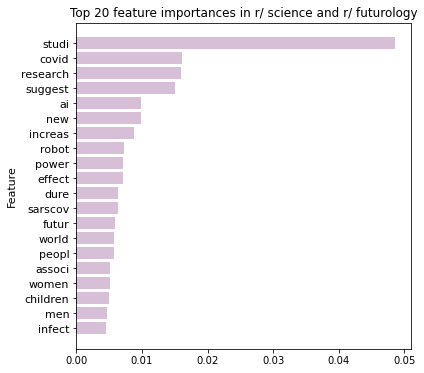

In [345]:
features = X_train_cvec.columns
importances = rf_ex_pipe.feature_importances_
indices = np.argsort(importances)[-20:]

plt.subplots(figsize = (6, 6))
plt.barh(range(len(indices)), importances[indices], color = 'thistle')
plt.yticks(range(len(indices)), [features[i] for i in indices], size = 11);
plt.title('Top 20 feature importances in r/ science and r/ futurology', size = 12)
plt.ylabel('Feature', size = 11);

# ref: https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [314]:
from sklearn.feature_selection import SelectFromModel

# This SelectFromModel library is a meta-transformer for selecting features based on importance weights

selected_from_model = SelectFromModel(estimator = RandomForestClassifier()).fit(X_train_cvec, y_train)

# ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [316]:
# Let's look at the strongest coefficients by feature

printmd('**The strongest coefficients start from the top in the table below.**')
printmd('**Holding all else constant, the effect of the stemmed word `studi` is a 0.046 increase in classification ability.**')

feature_importances_df = (pd.DataFrame(selected_from_model.estimator_.feature_importances_,
                                      index = X_train_cvec.columns, columns = ['Coeff'])
                                      .sort_values('Coeff', ascending = False))
display(feature_importances_df[:20])

# Export to combine with other top 100 features that I'm able to pull from other models
feature_importances_df[:100].to_csv('../data/feature_selection/feature_selection_randomforest.csv')

**The strongest coefficients start from the top in the table below.**

**Holding all else constant, the effect of the stemmed word `studi` is a 0.046 increase in classification ability.**

,Coeff
studi,0.050425
suggest,0.015479
covid,0.013561
research,0.012980
increas,0.009638
new,0.009087
ai,0.008677
power,0.008580
dure,0.007330
robot,0.006877


#### Predictions

credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_

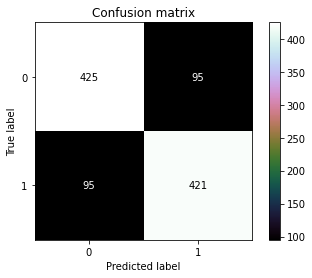

In [272]:
# Get predictions
preds = rf_ex_pipe.predict(X_test_cvec)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

display(plot_confusion_matrix(rf_ex_pipe, X_test_cvec, y_test, cmap='cubehelix', values_format='d'));
plt.title('Confusion matrix')

printmd('credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_')

In [273]:
# Calculate the accuracy

acc = (tp + tn) / (tp + fp + tn + fn)
print('Accuracy:', acc)

# Calculate the misclassification rate

misclass = (fp + fn) / (tp + fp + tn + fn)
print('Misclassification:', misclass)

# Calculate the sensitivity

sens = tp / (tp + fn)
print('Sensitivity:', sens)

# Calculate the precision

prec = tp / (tp + fp)
print('Precision:', prec)

# Calculate the specificity

spec = tn / (tn + fp)
print('Specificity:', spec)

# credit: Heather Robinson at General Assembly  :-)

Accuracy: 0.8166023166023166
Misclassification: 0.1833976833976834
Sensitivity: 0.8158914728682171
Precision: 0.8158914728682171
Specificity: 0.8173076923076923


In [196]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Random Forest (estimator)

pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier()) 
])


# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_rf_params = {
    'cvec__max_features': [5_000],
    'cvec__min_df': [1],
    'cvec__max_df': [.75],
    'cvec__ngram_range': [(1,1)],
    'rf__n_estimators': [100, 200], 
    'rf__max_depth': [None, .25],
    'rf__max_features': ['auto', 2_000]
}

# Instantiate GridSearchCV.

gs_cvec_rf = GridSearchCV(pipe_cvec_rf,             # the object we are optimizing
                  param_grid = pipe_cvec_rf_params, # the parameters values we are searching
                  cv = 5)                           # Number of folds in cross-validation

In [197]:
# Fit GridSearch to data.
gs_cvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.75], 'cvec__max_features': [5000],
                         'cvec__min_df': [1], 'cvec__ngram_range': [(1, 1)],
                         'rf__max_depth': [None, 0.25],
                         'rf__max_features': ['auto', 2000],
                         'rf__n_estimators': [100, 200]})

<br>

### Logistic Regression models with CountVectorizer transformed data

### CountVectorizer

In [525]:
# Instantiate CountVectorizer
cvec = CountVectorizer(max_df = 0.4, max_features = 6_000, min_df = 1, ngram_range = (1, 2), stop_words = 'english')

# Fit the features training data so the model learns the vocabulary; transform to create vectors from the vocabulary
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                           columns = cvec.get_feature_names())

# Fit the features test data so the model learns the vocabulary; 
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(),
                           columns = cvec.get_feature_names())

# Check the shapes 

display(X_train_cvec.shape)
display(y_train.shape)
display(X_test_cvec.shape)
display(y_test.shape)

(2101, 6000)

(2101,)

(1036, 6000)

(1036,)

#### Logistic Regression model 1

In [524]:
# Instantiate the model
logreg = LogisticRegression()

In [506]:
# Fit the model to train data
logreg.fit(X_train_cvec, y_train)

# Get accuracy scores for train and test data
printmd(f'**Accuracy score on train data: {logreg.score(X_train_cvec, y_train):.3f}**')
printmd(f'**Accuracy score on test data: {logreg.score(X_test_cvec, y_test):.3f}**')
printmd('**The model is overfit**')

**Accuracy score on train data: 0.996**

**Accuracy score on test data: 0.835**

**The model is overfit**

#### Predictions

credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_

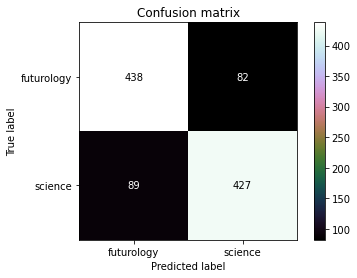

In [507]:
# Get predictions
preds = logreg.predict(X_test_cvec)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

display(plot_confusion_matrix(logreg, X_test_cvec, y_test, cmap='cubehelix', values_format='d'))
plt.title('Confusion matrix');

printmd('credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_')

**This model is misclassifying `futurology` posts as `science`. Let's see how the next model improves on this.**

#### Logistic Regression model 2

In [524]:
# Instantiate the model
logreg = LogisticRegression()

In [516]:
# Set new parameters
params = { 'C': [.001, .01, .1, 1], 
              'penalty': ['l1', 'l2']}

# Instantiate GridSearch cross-validation
gs = GridSearchCV(logreg, params, cv = 5)

gs.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']})

In [518]:
# Get accuracy scores for train and test data
printmd(f'**Accuracy score on train data: {gs.score(X_train_cvec, y_train):.3f}**')
printmd(f'**Accuracy score on test data: {gs.score(X_test_cvec, y_test):.3f}**')
printmd('**The model is still overfit, no improvement**')

printmd('**Best parameters:**')
display(gs.best_params_)

**Accuracy score on train data: 0.996**

**Accuracy score on test data: 0.835**

**The model is still overfit, no improvement**

**Best parameters:**

{'C': 1, 'penalty': 'l2'}

#### Logistic Regression model 3

In [534]:
params = {'solver': ['liblinear', 'sag'],
               'C': [1], 
               'penalty': ['l2']
              }

gs = GridSearchCV(log_reg, params, cv = 5)

gs.fit(X_train_cvec, y_train)
   
# ref: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451    

# Get accuracy scores for train and test data
printmd(f'**Accuracy score on train data: {gs.score(X_train_cvec, y_train):.3f}**')
printmd(f'**Accuracy score on test data: {gs.score(X_test_cvec, y_test):.3f}**')
printmd('**The model is still overfit**')

printmd('**Best parameters:**')
display(gs.best_params_)

**Accuracy score on train data: 0.996**

**Accuracy score on test data: 0.837**

**The model is still overfit**

**Best parameters:**

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

In [536]:
log_reg = LogisticRegression(C = 1, penalty = 'l2', solver = 'liblinear', random_state = 42)

log_reg.fit(X_train_cvec, y_train)

LogisticRegression(C=1, random_state=42, solver='liblinear')

#### Predictions

credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_

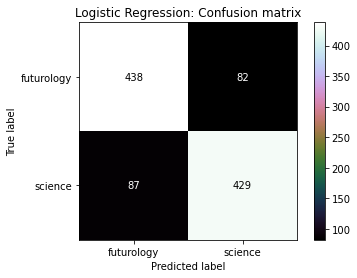

In [537]:
# Get predictions
preds = log_reg.predict(X_test_cvec)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

display(plot_confusion_matrix(log_reg, X_test_cvec, y_test, cmap='cubehelix', values_format='d'))
plt.title('Logistic Regression: Confusion matrix')
plt.savefig('../images/confusion_matrix_logreg.png')

printmd('credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_')

#### This model improved on the misclassifying of `science` posts as `futurology` by ***only two posts!*** (`0` predicted / `1` true went from 89 to 87).

**Let's see how the Random Forest model improves on this.**

In [551]:
printmd('**The strongest coefficients start from the top in the table below.**')
printmd(f'***Holding all else constant, the effect of `studi` is a {log_reg_coef.T.iloc[0, 0]:.1f} times evidence that we can predict classes accurately using vocabulary.***')

log_reg_coef = pd.DataFrame(log_reg.coef_.T, index = X_train_tvec.columns, columns = ['Coefficient']).sort_values('Coefficient', ascending = False)
display(log_reg_coef[:10])

**The strongest coefficients start from the top in the table below.**

***Holding all else constant, the effect of `studi` is a 1.9 times evidence that we can predict classes accurately using vocabulary.***

,Coefficient
studi,1.883410
covid,1.627200
suggest,1.421749
dure,1.328131
sarscov,1.250659
analysi,1.178087
bird,1.163955
new research,1.125783
increas,1.089082
associ,1.052911


### Random Forest models

#### Random Forest model 1

In [86]:
rf = RandomForestClassifier()

params_rf = {
    'n_estimators': [25, 100],
    'max_depth': [None, 100],
    'max_features': ['auto', 500]
        }


gs_rf = GridSearchCV(rf, param_grid = params_rf)
gs_rf.fit(X_train_cvec, y_train)

print(gs_rf.best_score_)  # cross val score
print(gs_rf.best_params_)  # cross val score

0.7844278316930147
{'max_depth': 100, 'max_features': 'auto', 'n_estimators': 100}


#### Random Forest model 2

In [91]:
rf = RandomForestClassifier()

params_rf_2 = {
    'n_estimators': [100],
    'max_depth': [100, 150],
    'max_features': ['auto', .5]
        }


gs_rf_2 = GridSearchCV(rf, param_grid = params_rf_2)
gs_rf_2.fit(X_train_cvec, y_train)

printmd('**Grid searched:**')
display(gs_rf_2.param_grid)
printmd(f'**Best accuracy score**: {round(gs_rf_2.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_rf_2.best_estimator_)
display(gs_rf_2.best_params_)

# Get accuracy scores for train and test data
printmd(f'**Accuracy score on train data: {gs_rf_2.score(X_train_tvec, y_train):.3f}**')
printmd(f'**Accuracy score on test data: {gs_rf_2.score(X_test_tvec, y_test):.3f}**')
printmd('**The model is still overfit**')

**Grid searched:**

{'n_estimators': [100], 'max_depth': [100, 150], 'max_features': ['auto', 0.5]}

**Best accuracy score**: 0.7911

**Best estimator / parameters:**

RandomForestClassifier(max_depth=150)

{'max_depth': 150, 'max_features': 'auto', 'n_estimators': 100}

**Accuracy score on train data: 0.486**

**Accuracy score on test data: 0.487**

**The model is still overfit**

## Model results scoreboard

| Model # | Accuracy (test) | Accuracy (train) |      Estimator      |  Estimator hyperparameters |   Transformer   | Transformer hyperparameters (best) |
|:-------:|:---------------:|:----------------------:|:-------------------:|:--------------------------:|:---------------:|:----------------------------------:|
|    1    |      83.5%      |          99.6%         | Logistic Regression |           Default          | CountVectorizer |            max_df = 0.4            |
|    1    |                 |                        |                     |                            |                 |        max_features = 6_000        |
|    1    |                 |                        |                     |                            |                 |             min_df = 1             |
|    1    |                 |                        |                     |                            |                 |        ngram_range = (1, 2)        |
|    1    |                 |                        |                     |                            |                 |       stop_words = 'english'       |
|    2    |      83.5%      |          99.6%         | Logistic Regression |       penalty = 'l2'       | CountVectorizer |           Same as model 1          |
|    2    |                 |                        |                     |            C = 1           |                 |                                    |
|    3    |      83.7%      |          99.6%         | Logistic Regression |       penalty = 'l2'       | CountVectorizer |           Same as model 1          |
|    3    |                 |                        |                     |            C = 1           |                 |                                    |
|    3    |                 |                        |                     |    'solver': 'liblinear'   |                 |                                    |
|    4    |      82.7%      |           1.0          |    Random Forest    |    'rf__max_depth': None   | CountVectorizer |             max_df=0.75            |
|    4    |                 |                        |                     | 'rf__max_features': 'auto' |                 |          max_features=5000         |
|    4    |                 |                        |                     |   'rf__n_estimators': 100  |                 |          'cvec__min_df': 1         |

<br></br>

<br></br>

#### Set the features

In [332]:
# Set feature matrix and target variable
X_selected_features = selected_features_df.drop(columns = 'subreddit')
y_selected_features = selected_features_df['subreddit']

In [333]:
display(X_selected_features.shape)
display(y_selected_features.shape)

(2, 137)

(2,)

### Train-test split

In [337]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected_features,
                                                    y_selected_features,
                                                    test_size = 0.33,
                                                    stratify = y,             # equal balance of yes and no in train and test
                                                    random_state = 42)

print('X_train shape:', X_train_sel.shape)
print('y_train shape:', y_train_sel.shape, '\n')
print('X_test shape:', X_test_sel.shape)
print('y_test shape:', y_test_sel.shape)

ValueError: Found input variables with inconsistent numbers of samples: [2, 3137]

### Baseline accuracy

**50% is the baseline accuracy percentage we compare with the model's accuracy.**

**If the model does better than the baseline, then it is better than null model (predicting the majority class).**

In [336]:
printmd('**Balance of classes in `y`**')
display(y_selected_features.value_counts(normalize=True))

# printmd('**Balance of classes in `y_train`**')
# display(y_train.value_counts(normalize=True))

# printmd('**Balance of classes in `y_test`**')
# y_test.value_counts(normalize=True)

**Balance of classes in `y`**

1    0.5
0    0.5
Name: subreddit, dtype: float64

#### Logistic Regression model using manually selected features

In [296]:
params = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
               'C': [.0001, .001, .01, .1, 1], 
               'penalty': ['l1', 'l2']
              }

log_reg = LogisticRegression(C=1, random_state=42)

clf = GridSearchCV(log_reg, params, cv=5)

clf.fit(X_train_tvec, y_train)

scores = clf.cv_results_['mean_test_score']
   
# ref: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451    

KeyboardInterrupt: 

In [11]:
printmd('**Grid searched:**')
display(clf.param_grid)
printmd(f'**Best accuracy score**: {round(clf.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(clf.best_estimator_)
display(clf.best_params_)

# Get accuracy scores for train and test data
printmd(f'**Accuracy score on train data: {clf.score(X_train_tvec, y_train):.3f}**')
printmd(f'**Accuracy score on test data: {clf.score(X_test_tvec, y_test):.3f}**')
printmd('**The model is still overfit**')

**Grid searched:**

{'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
 'C': [0.0001, 0.001, 0.01, 0.1, 1],
 'penalty': ['l1', 'l2']}

**Best accuracy score**: 0.8267

**Best estimator / parameters:**

LogisticRegression(C=1, random_state=42, solver='liblinear')

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

**Accuracy score on train data: 0.959**

**Accuracy score on test data: 0.835**

**The model is still overfit**

In [297]:
log_reg = LogisticRegression(C = 1, penalty = 'l2', solver = 'liblinear', random_state=42)

log_reg.fit(X_train_tvec, y_train)

LogisticRegression(C=1, random_state=42, solver='liblinear')

In [301]:
log_reg.intercept_, log_reg.coef_

(array([-0.13744292]),
 array([[-0.10524177,  0.62591884,  0.09646383, ...,  0.06160046,
         -0.12670566,  0.06088419]]))

In [304]:
printmd('**The strongest coefficients start from the top in the table below.**')
printmd(f'***Holding all else constant, the effect of `studi` is a {log_reg_coef.T.iloc[0, 0]:.1f} times increase in predictive accuracy.***')

log_reg_coef = pd.DataFrame(log_reg.coef_.T, index = X_train_tvec.columns, columns = ['Coeff']).sort_values('Coeff', ascending = False)
display(log_reg_coef[:20])

# Export to combine with other top 100 features that I'm able to pull from other models
log_reg_coef[:100].to_csv('../data/feature_selection/feature_selection_logreg.csv')

**The strongest coefficients start from the top in the table below.**

***Holding all else constant, the effect of `studi` is a 4.6 times increase in predictive accuracy.***

,Coeff
studi,4.569888
covid,2.735273
suggest,2.426959
new studi,2.098700
research,2.056223
increas,1.790901
effect,1.653257
dure,1.635006
peopl,1.596396
sarscov,1.549757
